## Visualizations and CAM

Playing with some fun visualization tricks. Two well-known CNN architectures: AlexNet and VGG-16 Net used to demonstrate visual patterns learned in the filters. Introduced Grad-CAM, which visualizes the attended heat map, where the CNN looks at while predicting the labels of the images.


In [1]:
# A bit of setups
import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
from lib.datasets import *

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg

%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hensden/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

### Download the Model
Download the vgg16 pretrained model from the [ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy](ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy)  
Download the AlexNet pretrained model from the link [BVLC_ALEXNET](http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy)  
And save the two models (.npy files) to `lib/tf_models/`

In [2]:
import numpy as np
from lib.tf_models import vgg16
import os
import math

### Visualizing learned filters 
Visualize the learned convolutional filters.

In [3]:
# Define the vgg network for visualizations
vgg_viz = vgg16.Vgg16()
vgg_viz.load()
vgg_viz.setup()


Model from /home/hensden/usc/fall19/deeplearning/csci566-assignment1/lib/tf_models/vgg16.npy
Pretrained VGG16 successfully loaded!




In [4]:
# Useful function to arrange the images to be shown as a squared grid
def viz_grid(Xs, ubound=255.0, padding=1):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

Model from lib/tf_models/bvlc_alexnet.npy
Pretrained AlexNet successfully loaded!
Model from lib/tf_models/vgg16.npy
Pretrained Vgg-16 successfully loaded!


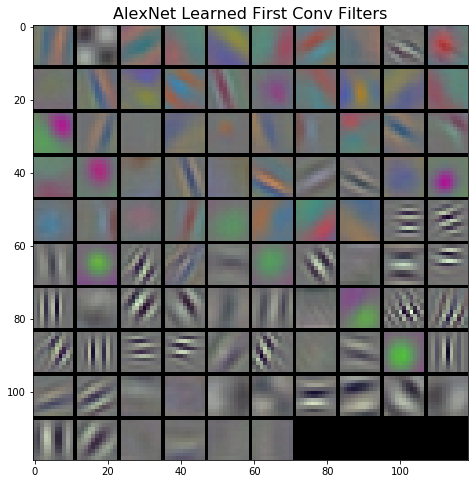

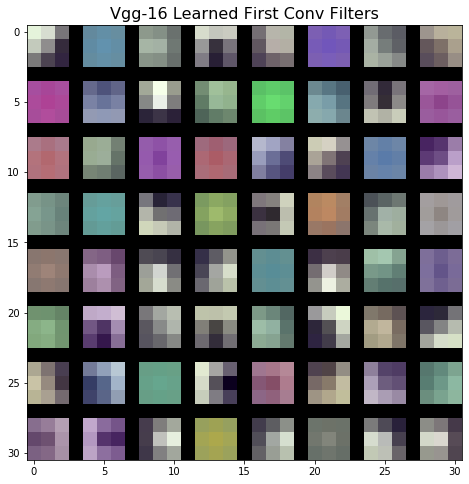

In [5]:
model_paths = {
    "Vgg-16": os.path.join("lib", "tf_models", "vgg16.npy"),
    "AlexNet": os.path.join("lib", "tf_models", "bvlc_alexnet.npy")
}

for net in sorted(model_paths):
    model_path = model_paths[net]
    print("Model from {}".format(model_path))
    pretrained = np.load(model_path, encoding='latin1', allow_pickle=True).item()
    print("Pretrained {} successfully loaded!".format(net))

    first_conv = "conv1_1" if net == "Vgg-16" else "conv1"
    
    conv1 = pretrained[first_conv]
    weight, bias = conv1[0], conv1[1]
    
    Nr = weight - weight.min()
    Dr = weight.max() - weight.min()
    w_01 = Nr/Dr
    # print(w_01.shape)

    
    # current shape H  W  C  n
    rgb_w = w_01.transpose(3,0,1,2)
    
    # Define a figure
    fig = plt.figure(figsize=(8,8))   
    ax1 = plt.subplot(111)
    
    # Grid the rgb_w
    grid = viz_grid(rgb_w)

    ax1.imshow(grid[...,::-1])
    ax1.set_title('{} Learned First Conv Filters'.format(net), fontsize=16)

## Visualizing convolution neural net

### Load CIFAR-10 Data

In [6]:
data_train, labels_train, data_test, labels_test = CIFAR10(os.path.join('data', 'cifar-10-batches-py'))

### <font color="Scarlet">Run the following lines of code, and whenever you encounter problems with tf graph, rerun them again<font>

In [7]:
tf.reset_default_graph()
sess = tf.Session()

### CNN Layers



In [1]:
# Define max pooling and conv layers
''''''
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

# Referencing : 
# https://www.tensorflow.org/guide/variables
# https://www.tensorflow.org/api_docs/python/tf/random/truncated_normal
# https://www.tensorflow.org/api_docs/python/tf/constant
def get_w(dim):
    return tf.Variable(tf.truncated_normal(dim, stddev=0.03))

def get_b(dim):
    return tf.Variable(tf.constant(0.09, shape=dim))


def flatten(input_layer):
    # input: input tensors
    '''D = 1
    for i in input_layer.get_shape()[1:]:
        D *= i
    tf.reshape(input_layer, [-1])
    return input_layer'''
    return tf.contrib.layers.flatten(input_layer)

def fc(input_layer, num_output):
    # input: input tensors
    # num_output: int, the output dimension
    return tf.linalg.matmul(input_layer, get_w([int(input_layer.get_shape()[1]),num_output])) + get_b([num_output])


# Data Augmentation methods
# Source : https://www.tensorflow.org/tutorials/images/deep_cnn
def flip(im):
    return tf.image.random_flip_left_right(im)

def brighten(im):
    return tf.image.random_brightness(im, 0.23)

def vary(im):
    return tf.image.random_contrast(im, 0.5, 1.4)
    
# Batch Normalisation
def BN(input_layer, layer_id):
    return tf.contrib.layers.batch_norm(input_layer, scale=True,
                                        scope=layer_id)



### CNN Layers

In [9]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 64
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):

            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            # batchnorm
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        self.flat = flatten(self.pool2)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            self.fc4 = fc(self.relu3, 10)
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        self.is_train = True
        
    def _build_optimizer(self):
        S = tf.Variable(0, trainable=False)
        l0 = 5e-4
        lt = tf.train.exponential_decay(l0,decay_steps=500,global_step=S,
                                                         decay_rate=0.96,staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate=lt).minimize(loss=self.loss_op,
                                                                           global_step=S)
        
    def _loss(self, labels, logits):
        self.loss_op = tf.losses.softmax_cross_entropy(onehot_labels=labels,
                                                       logits=logits)
        
    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {self.X:X_, self.Y:Y_}
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        # Graph 1. X: iteration (training step), Y: training loss
        #plt.subplot(1,2,1)
        plt.subplot(2,1,1)
        plt.title('Training loss')
        plt.xlabel('Iteration (training step)')
        plt.plot(range(len(losses)), losses, label='Loss')
        # Graph 2. X: epoch, Y: training accuracy
        #plt.subplot(1,2,2)
        plt.subplot(2,1,2)
        plt.title('Training accuracy')
        plt.xlabel('Epoch')
        plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
        # Display
        plt.gcf().set_size_inches(15, 15)
        plt.show()
        
        
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            feed_dict = {self.X:X_, self.Y:Y_}
            self.is_train = False
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter


In [10]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 10
                            
        
        
    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        print('input layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            print('conv1 layer: ' + str(self.relu1.get_shape()))
        
        with tf.variable_scope('drop0'):
            self.drop0 = tf.nn.dropout(self.relu1, 0.69)
            
        with tf.variable_scope('bn1'):
            self.bn1 = BN(self.drop0, 'bn1')
            print('bn1 layer: ' + str(self.bn1.get_shape()))
            
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.bn1, 7, 1, 32)
            self.relu2 = tf.nn.relu(self.conv2)
            print('conv2 layer: ' + str(self.relu2.get_shape()))
            
        with tf.variable_scope('bn2'):
            self.bn2 = BN(self.relu2, 'bn2')
            print('bn2 layer: ' + str(self.bn2.get_shape()))
        
        with tf.variable_scope('pool1'):
            self.pool1 = max_pool(self.bn2,3,2)
            print('pool1 layer: ' + str(self.pool1.get_shape()))
        
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool1, 5, 1, 64)
            self.relu3 = tf.nn.relu(self.conv3)
            print('conv3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('drop1'):
            self.drop1 = tf.nn.dropout(self.relu3, 0.69)
                    
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.drop1, 5, 1, 64)
            self.relu4 = tf.nn.relu(self.conv4)
            print('conv4 layer: ' + str(self.relu4.get_shape()))
        
        with tf.variable_scope('bn3'):
            self.bn3 = BN(self.relu4, 'bn3')
            print('bn3 layer: ' + str(self.bn3.get_shape()))
            
        with tf.variable_scope('pool2'):
            self.pool2 = max_pool(self.bn3, 3, 2)
            print('pool2 layer: ' + str(self.pool2.get_shape()))
        
        with tf.variable_scope('drop2'):
            self.drop2 = tf.nn.dropout(self.pool2, 0.69)           

        self.flat = flatten(self.drop2)
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc1'):
            self.fc1 = fc(self.flat, 768)
            self.relu6 = tf.nn.relu(self.fc1)
            print('fc1 layer: ' + str(self.relu6.get_shape()))
        
        with tf.variable_scope('fc2'):
            self.fc2 = fc(self.relu6, 384)
            self.relu7 = tf.nn.relu(self.fc1)
            print('fc2 layer: ' + str(self.relu7.get_shape()))
            
        with tf.variable_scope('fc3'):
            self.fc3 = fc(self.relu7, 10)
            print('fc3 layer: ' + str(self.fc3.get_shape()))
            
        # Return the last layer
        return self.fc3


### Visualizing the learned filters on our trained CIFAR-10 network!


In [11]:
def restore_model(saved_file):
    # Restore the model using parameters dict
    variables = tf.global_variables()
    param_dict = {}
    for var in variables:
        var_name = var.name[:-2]
        print('Loading {} from checkpoint. Name: {}'.format(var.name, var_name))
        param_dict[var_name] = var
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join('lib', 'tf_models', 'problem2', saved_file))

In [12]:
# TODO:
def viz_model(model_name):
    with sess.as_default():
        with tf.variable_scope("conv1", reuse=True):
            conv1 = tf.get_variable("w")
            b1    = tf.get_variable("b")
        print (conv1.shape, b1.shape)

        weight = conv1.eval()
        bias = b1.eval()

        Nr = weight - weight.min()
        Dr = weight.max() - weight.min()
        w_01 = Nr/Dr
        rgb_w = w_01.transpose(3,0,1,2)

        # Define a figure
        fig = plt.figure(figsize=(8,8))   
        ax1 = plt.subplot(111)

        grid = viz_grid(rgb_w)

        ax1.imshow(grid[...,::-1])
        ax1.set_title('{} Learned First Conv Filters'.format(model_name), fontsize=16)

### Visualize Base Model 

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading fc3/Variable:0 from checkpoint. Name: fc3/Variable
Loading fc3/Variable_1:0

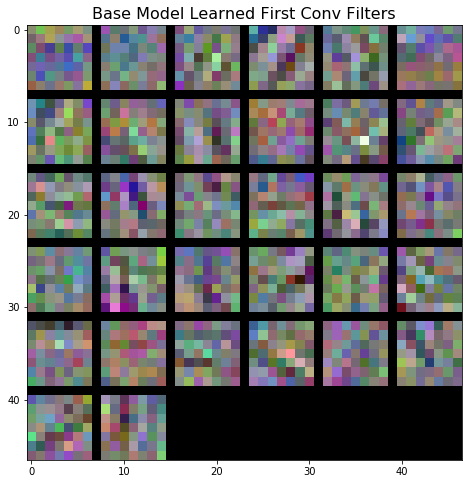

In [13]:
# Reset TF Graph
tf.reset_default_graph()
sess = tf.Session()

# Load BaseModel
model = BaseModel()
restore_model('csci-599_sample.ckpt')
viz_model('Base Model')

### Visualize Your Model [5pt]

-----  Your model  -----
input layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
bn1 layer: (?, 32, 32, 32)
conv2 layer: (?, 32, 32, 32)
bn2 layer: (?, 32, 32, 32)
pool1 layer: (?, 16, 16, 32)
conv3 layer: (?, 16, 16, 64)
conv4 layer: (?, 16, 16, 64)
bn3 layer: (?, 16, 16, 64)
pool2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc1 layer: (?, 768)
fc2 layer: (?, 768)
fc3 layer: (?, 10)
Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading bn1/bn1/gamma:0 from checkpoint. Name: bn1/bn1/gamma
Loading bn1/bn1/beta:0 from checkpoint. Name: bn1/bn1/beta
Loading bn1/bn1/moving_mean:0 from checkpoint. Name: bn1/bn1/moving_mean
Loading bn1/bn1/moving_variance:0 from checkpoint. Name: bn1/bn1/moving_variance
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading bn2/bn2/gamma:0 from

(7, 7, 3, 32) (1, 1, 1, 32)


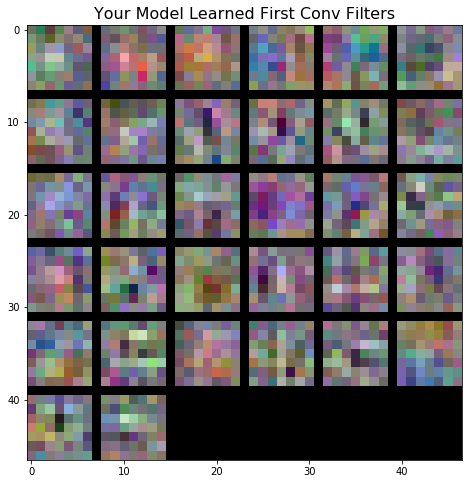

In [14]:
# Reset TF Graph
tf.reset_default_graph()
sess = tf.Session()

# Load BaseModel
model = YourModel()
restore_model('csci-599_mine.ckpt')
viz_model('Your Model')


The **base model** has a **broad capture of the edges**. There is **more relevant information (and fine-grained details)** in the **second (my) model**. *There is more variance in color space captured and more information regarding target shape*. We can see that from the darker regions near the centre of the filters, and can make out that most objects of interest lie near the center of the image. *This is happening because of more number of layers in my model, therefore more fine grained information is captured.*

## Visualizing Activations
Now that we have seen the learned filters, and observed that they have some patterns, we will go one step further to visualize the activation maps produced by different convolutional filters. You will see that as we go deeper through the layers of a network the activation maps gradually represent higher and higher levels of abstraction in the images.
Now, let's get some warm-up by running the following visualization code blocks for a simple model trained on MNIST dataset.

In [15]:
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data

In [16]:
mnist = input_data.read_data_sets(os.path.join('data', 'MNIST_data'), one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [17]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 784],name="x-in")
y = tf.placeholder(tf.float32, [None, 10],name="y-in")
keep_prob = tf.placeholder("float")

x_reshaped = tf.reshape(x,[-1,28,28,1])
x_tiled = tf.tile(x_reshaped, [1,1,1,3])
sconv_1 = slim.conv2d(x_tiled,5,[5,5], activation_fn=None)
srelu_1 = tf.nn.relu(sconv_1)
spool_1 = slim.max_pool2d(srelu_1,[2,2])

sconv_2 = slim.conv2d(spool_1,5,[5,5], activation_fn=None)
srelu_2 = tf.nn.relu(sconv_2)
spool_2 = slim.max_pool2d(srelu_2,[2,2])

sconv_3 = slim.conv2d(spool_2,20,[5,5], activation_fn=None)
srelu_3 = tf.nn.relu(srelu_2)
s_dropout3 = slim.dropout(srelu_3, keep_prob)
output = slim.fully_connected(slim.flatten(s_dropout3), 10, activation_fn=tf.nn.softmax)

cross_entropy = -tf.reduce_sum(y * tf.log(output))
correct_prediction = tf.equal(tf.argmax(output,1 ), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [18]:
batchSize = 50
dropout_p = 0.5

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# Train the network
for i in range(2001):
    batch = mnist.train.next_batch(batchSize)
    sess.run(train_step, feed_dict={x:batch[0], y:batch[1], keep_prob:dropout_p})
    if i % 100 == 0 and i != 0:
        trainAccuracy = sess.run(accuracy, feed_dict={x:batch[0], y:batch[1], keep_prob:1.0})
        print("step %d, training accuracy %g"%(i, trainAccuracy))

step 100, training accuracy 0.38
step 200, training accuracy 0.78
step 300, training accuracy 0.74
step 400, training accuracy 0.86
step 500, training accuracy 0.74
step 600, training accuracy 0.76
step 700, training accuracy 0.9
step 800, training accuracy 0.92
step 900, training accuracy 0.86
step 1000, training accuracy 0.88
step 1100, training accuracy 0.92
step 1200, training accuracy 0.92
step 1300, training accuracy 0.9
step 1400, training accuracy 0.96
step 1500, training accuracy 0.84
step 1600, training accuracy 0.94
step 1700, training accuracy 0.86
step 1800, training accuracy 0.96
step 1900, training accuracy 0.92
step 2000, training accuracy 0.98


In [19]:
testAccuracy = sess.run(accuracy, feed_dict={x:mnist.test.images,y:mnist.test.labels, keep_prob:1.0})
print("test accuracy {}".format(testAccuracy))

test accuracy 0.9157999753952026


In [20]:
# function for visualizing the activations
def getActivations_mnist(layer, features):
    outs = sess.run(layer, feed_dict={x:np.reshape(features,[1,784],order='F'), keep_prob:1.0})
    outs = np.transpose(outs, [3, 1, 2, 0])
    fig = plt.figure(figsize=(4,4))
    ax1 = plt.subplot(111)
    grid = viz_grid(outs)
    ax1.imshow(grid[...,0])
    ax1.set_title('{} Activations'.format(layer.name), fontsize=16)

The Image for activation visualizations:


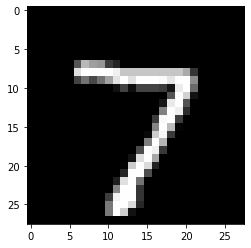

In [21]:
imageToUse = mnist.test.images[0]
imageToShow = np.expand_dims(np.reshape(imageToUse,[28,28]), axis=-1)
imageToShow = np.tile(imageToShow, (1,1,3))
plt.imshow(imageToShow, interpolation="nearest", cmap="gray")
print ("The Image for activation visualizations:")

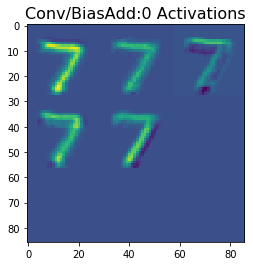

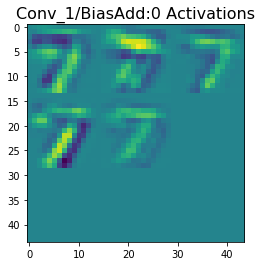

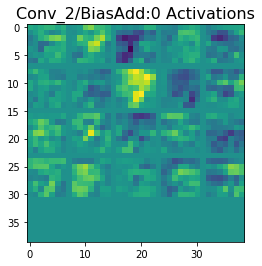

In [22]:
# Visualize the first 3 activation maps after convolution layers (without ReLU)
getActivations_mnist(sconv_1, imageToUse)
getActivations_mnist(sconv_2, imageToUse)
getActivations_mnist(sconv_3, imageToUse)

## Visualize the activations on your own model 

In [23]:
def getActivations_cifar10(layer, input_batch):
    # model has YourModel loaded already 
    units = None
    units = sess.run(layer, feed_dict={model.X:input_batch})
    units = np.transpose(units, [3, 1, 2, 0])
    # Define the figure
    fig = plt.figure(figsize=(8,8))   
    ax1 = plt.subplot(111)
    grid = viz_grid(units)
    ax1.imshow(grid[...,0])
    ax1.set_title('{} Activations'.format(layer.name), fontsize=16)

There are total 10000 images in test set
Image 998 in test set


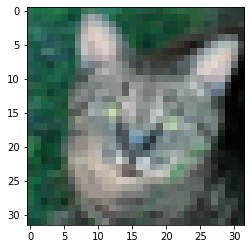

In [24]:
print ("There are total {} images in test set".format(len(data_test)))
query_idx = 998
# query_idx = np.random.randint(0,999)
# Process the indicated issue
query_idx = min(max(query_idx, 0), 999)
cifar10ToUse = data_test[query_idx].astype(np.uint8)
cifar10ToUse= cifar10ToUse[...,::-1]
plt.imshow(cifar10ToUse)
print ("Image {} in test set".format(query_idx))

In [25]:
tf.reset_default_graph()
sess = tf.Session()

# Restore the model using parameters dict
model = BaseModel()
restore_model('csci-599_sample.ckpt')

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
Loading conv1/w:0 from checkpoint. Name: conv1/w
Loading conv1/b:0 from checkpoint. Name: conv1/b
Loading conv2/w:0 from checkpoint. Name: conv2/w
Loading conv2/b:0 from checkpoint. Name: conv2/b
Loading fc3/Variable:0 from checkpoint. Name: fc3/Variable
Loading fc3/Variable_1:0 from checkpoint. Name: fc3/Variable_1
Loading fc4/Variable:0 from checkpoint. Name: fc4/Variable
Loading fc4/Variable_1:0 from checkpoint. Name: fc4/Variable_1
Loading Variable:0 from checkpoint. Name: Variable
Loading beta1_power:0 from checkpoint. Name: beta1_power
Loading beta2_power:0 from checkpoint. Name: beta2_power
Loading conv1/w/Adam:0 from checkpoint. Name: conv1/w/Adam
Loading conv1/w/Adam_1:0 from checkpoint. Name: conv1/w/Adam_1
Loading conv1/b/Adam:0 from checkpoint. Name: conv1/b/Adam
Loading conv

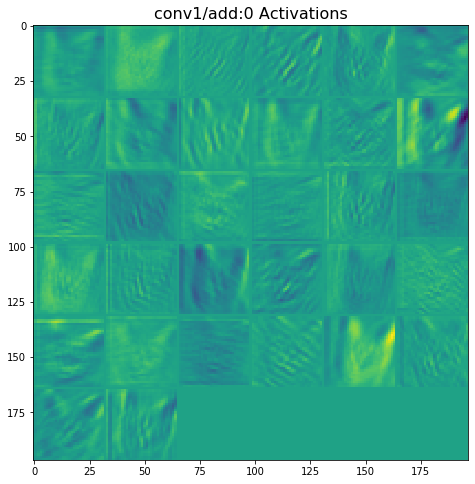

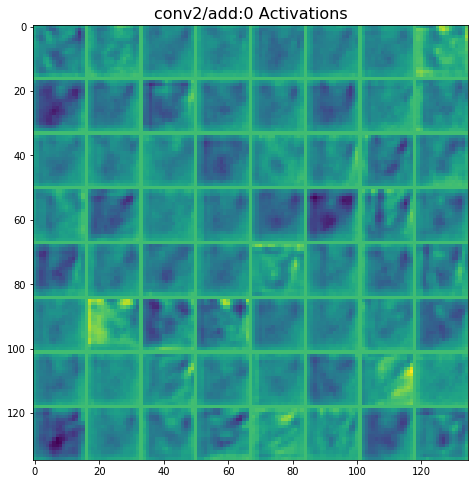

In [26]:
cifar10ToUse_with_batch = np.expand_dims(cifar10ToUse, axis=0)
with sess.as_default():
    getActivations_cifar10(model.conv1, cifar10ToUse_with_batch)
    getActivations_cifar10(model.conv2, cifar10ToUse_with_batch)

In the first layer of convolution there are `32 filters`, and in the second layer, there are `64 filters`. *Each filter is unique and captures different information during the convolution.* We can observe that the shape of the cat's face, is being captured across all the filters. This shows that the network learns the shape of face of the cat and will use this information during inference. **In `conv1` the high level features like edges and sharp points are captured well**. **In `conv2`**, as the network forward propagates, the visualization shows that every filter becomes more abstracted. **It captures nuances and finer details better.** 

## Gradient-weighted Class Activation Mapping (Grad-CAM)
Grad-CAM is a technique for "visually interpreting" the predictions of a Convolutional Neural
Network (CNN)-based model. This technique essentially uses the gradients of any target concept
(a predicted class such as "cat"), flowing into the final convolutional layer to produce a coarse localization
map, attending regions in the image that are important for prediction of the concept.
Please read the original paper [Grad-CAM](https://arxiv.org/abs/1610.02391) for more details.

### Register the guided backpropagation ReLU (Run this function only once)

In [27]:
# Replace vanila relu to guided relu to get guided backpropagation.
@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

### Some useful functions

In [28]:
import cv2

def imgread(path):
    print ("Image:", path.split("/")[-1])
    # Read in the image using python opencv
    img = cv2.imread(path)
    img = img / 255.0
    print ("Raw Image Shape: ", img.shape)
    
    # Center crop the image
    short_edge = min(img.shape[:2])
    W, H, C = img.shape
    to_crop = min(W, H)
    cent_w = int((img.shape[1] - short_edge) / 2)
    cent_h = int((img.shape[0] - short_edge) / 2)
    img_cropped = img[cent_h:cent_h+to_crop, cent_w:cent_w+to_crop]
    print ("Cropped Image Shape: ", img_cropped.shape)
    
    # Resize the cropped image to 224 by 224 for VGG16 network
    img_resized = cv2.resize(img_cropped, (224, 224), interpolation=cv2.INTER_LINEAR)
    print ("Resized Image Shape: ", img_resized.shape)
    return img_resized

def predicted_labels(score, synset_path):
    fi = open(synset_path, "rb")
    synset = []
    for line in fi:
        synset.append(line.rstrip().lstrip())
    
    # The predictions, reverse ordered
    pred = np.argsort(score)[::-1]

    # Top 1 and Top 5
    top1 = synset[pred[0]]
    print ("\nTop1, Label: {}, score: {}".format(top1, score[pred[0]]))
    top5 = [(synset[pred[i]], score[pred[i]]) for i in range(5)]
    for i in range(1,5):
        print ("Top{}, Label: {} score: {}".format(i+1, top5[i][0], top5[i][1]))
    return top1, top5

### Visualization Function

In [29]:
def visualize(image, output, grads, gb_grads):
    # Reverse the BGR channel to RGB
    gb_grads = gb_grads[...,::-1]

    # Initialzie CAM weights
    CAM = np.ones(output.shape[0 : 2], dtype = np.float32)  

    # Taking a weighted average
    cam_w = np.mean(grads, axis = (0, 1))
    for i, w in enumerate(cam_w):
        CAM += w * output[:, :, i]

    # Passing through ReLU
    CAM = np.maximum(CAM, 0)
    # scale CAM to [0,1]
    CAM /= np.max(CAM)
    # Resize the CAM to 224 by 224
    CAM = cv2.resize(CAM, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    # scale guided backprop gradients to [0,1]
    gb_grads -= np.min(gb_grads)
    gb_grads /= np.max(gb_grads)
    
    # scale the original to [0,1]
    img_toshow = image.astype(float)    
    img_toshow -= np.min(img_toshow)
    img_toshow /= img_toshow.max()

    # Render the CAM heatmap
    heatmap = cv2.applyColorMap(255 - np.uint8(CAM*255.0), cv2.COLORMAP_JET)

    # Grad-CAM
    CAM_gb = CAM.copy()
    CAM_gb = np.expand_dims(np.squeeze(CAM_gb), axis=-1)
    gd_gb = img_toshow[...,::-1] * np.tile(CAM_gb, (1,1,3))
    
    # Draw the results figures
    fig = plt.figure(figsize=(10,10))   
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)
    
    ax1.imshow(img_toshow[...,::-1])
    ax1.set_title('Input Image')
    ax2.imshow(heatmap)
    ax2.set_title('Grad-CAM')
    ax3.imshow(gb_grads)
    ax3.set_title('guided backpropagation')
    ax4.imshow(gd_gb)
    ax4.set_title('guided Grad-CAM')

    # Show the resulting image
    plt.show()

### Grad-CAM Main Implementation 

Visualization with GRAD-CAM over a pretrained VGG network.


e.g. vgg.conv2_2 extracts second convolution filter in conv2 family.

Image: corgi.jpg
Raw Image Shape:  (600, 900, 3)
Cropped Image Shape:  (600, 600, 3)
Resized Image Shape:  (224, 224, 3)
Image: cat_and_dog.jpg
Raw Image Shape:  (480, 640, 3)
Cropped Image Shape:  (480, 480, 3)
Resized Image Shape:  (224, 224, 3)
Image: cat_and_dog.jpg
Raw Image Shape:  (480, 640, 3)
Cropped Image Shape:  (480, 480, 3)
Resized Image Shape:  (224, 224, 3)
Model from /home/hensden/usc/fall19/deeplearning/csci566-assignment1/lib/tf_models/vgg16.npy
Pretrained VGG16 successfully loaded!
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Top1, Label: b'n02113186 Cardigan, Cardigan Welsh corgi', score: 0.3729476034641266
Top2, Label: b'n02113023 Pembroke, Pembroke Welsh corgi' score: 0.23948974907398224
Top3, Label: b'n02109961 Eskimo dog, husky' score: 0.21841900050640106
Top4, Label: b'n02110185 Siberian husky' score: 0.1045570969581604
Top5, Label: b'n02110063 malamute, malemute, Alaskan malamute' s

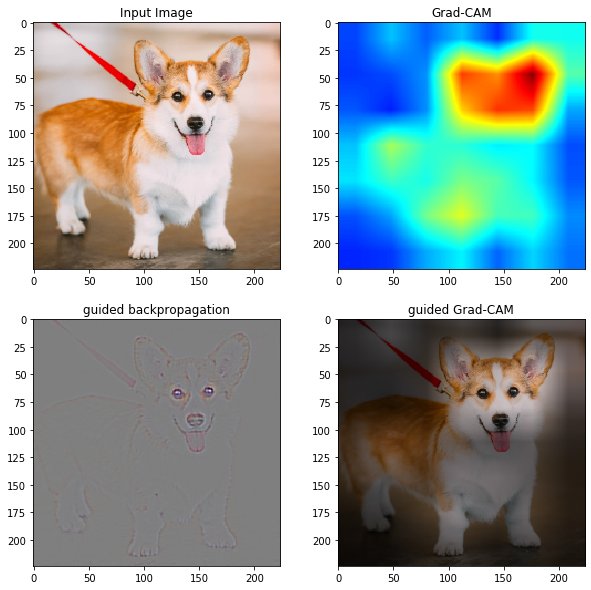


Top1, Label: b'n02110958 pug, pug-dog', score: 0.3903186023235321
Top2, Label: b'n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier' score: 0.1110232025384903
Top3, Label: b'n02123159 tiger cat' score: 0.08522199839353561
Top4, Label: b'n02108422 bull mastiff' score: 0.052628129720687866
Top5, Label: b'n02123045 tabby, tabby cat' score: 0.04932364821434021


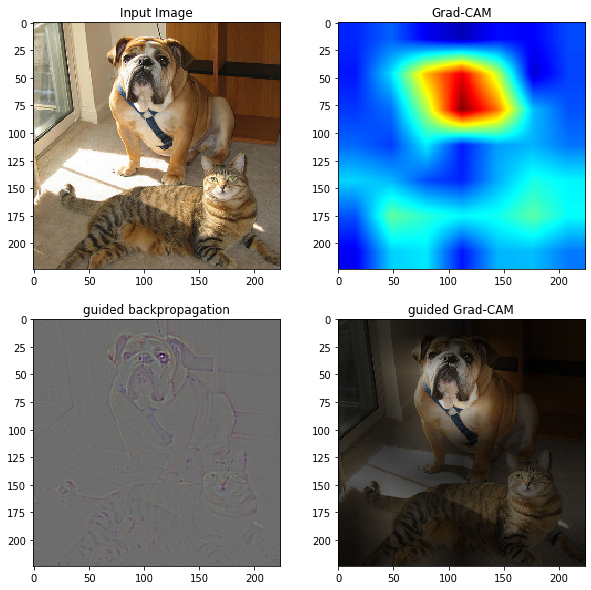


Top1, Label: b'n02110958 pug, pug-dog', score: 0.3903186023235321
Top2, Label: b'n02093428 American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier' score: 0.1110232025384903
Top3, Label: b'n02123159 tiger cat' score: 0.08522199839353561
Top4, Label: b'n02108422 bull mastiff' score: 0.052628129720687866
Top5, Label: b'n02123045 tabby, tabby cat' score: 0.04932364821434021


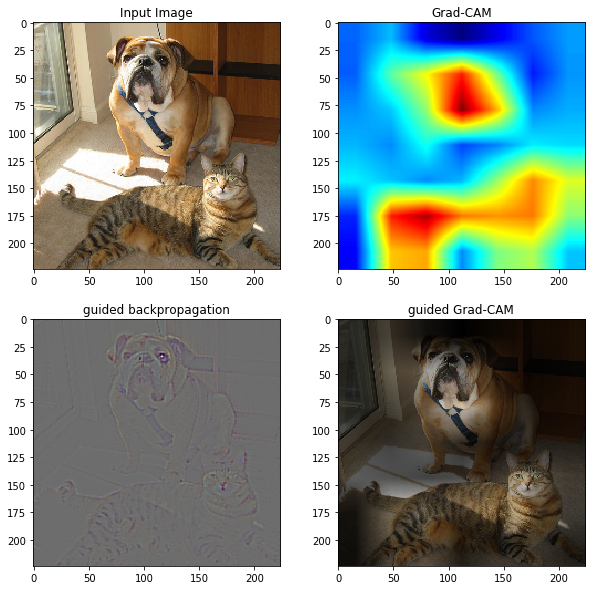

In [30]:
num_classes = 1000

# Read in the image
img1 = imgread(os.path.join("images", "corgi.jpg"))
img2 = imgread(os.path.join("images", "cat_and_dog.jpg"))
img3 = imgread(os.path.join("images", "cat_and_dog.jpg"))

# Expand one dimension to take on the batch dimension
img1 = np.expand_dims(img1, axis=0)
img2 = np.expand_dims(img2, axis=0)
img3 = np.expand_dims(img3, axis=0)

# Define a all zero gradients of the shape 1000
zero_grads = np.array([0 for i in range(num_classes)])

# The indices of the classes are provided for you
class_num1 = 263  # Pembroke, Pembroke Welsh corgi
class_num2 = 254  # Pug, pug-dog
class_num3 = 282  # Tiger cat

# Define a one-hot gradient vector where the only activated gradient
# is of the corresponding indices from above 
one_hot_grad1 = zero_grads.copy()
one_hot_grad2 = zero_grads.copy()
one_hot_grad3 = zero_grads.copy()
one_hot_grad1[class_num1] = 1.0
one_hot_grad2[class_num2] = 1.0
one_hot_grad3[class_num3] = 1.0
one_hot_grad1 = np.expand_dims(one_hot_grad1, axis=0)
one_hot_grad2 = np.expand_dims(one_hot_grad2, axis=0)
one_hot_grad3 = np.expand_dims(one_hot_grad3, axis=0)

minibatch = None
minibatch = np.concatenate((img1, img2, img3), axis=0)
labels = None
labels = np.concatenate((one_hot_grad1,one_hot_grad2,one_hot_grad3),axis=0)


# Define the batch size
batch_size = 3

# Create tensorflow graph for evaluation
graph = tf.Graph()
with graph.as_default():
    with graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        # Define the VGG16 network and setup
        # Please take a look at the lib/tf_models/vgg16.py for more details
        # of the VGG16 network
        vgg = vgg16.Vgg16()
        vgg.load()
        vgg.setup()
        
        signal = None
        loss = None
        signal = tf.multiply(vgg.fc8,tf.to_float(labels))
        loss = tf.reduce_mean(signal)

        pool5_grad = tf.gradients(loss, vgg.pool5)[0] # error vgg. need not be there

        inputs_grad = tf.gradients(loss, vgg.inputs)[0]

        eps = tf.constant(1e-5)
        pool5_grad_normed = pool5_grad / tf.norm(pool5_grad,  keep_dims=True) + eps

        init = tf.global_variables_initializer()
        
# Run tensorflow 
with tf.Session(graph=graph) as sess:    
    sess.run(init)
    # gb_grads, pool5_act, pool5_grads, prob = None sess.run 
    dic = {vgg.inputs:minibatch, vgg.labels:labels}
    gb_grads, pool5_act, pool5_grads, prob = sess.run([inputs_grad, vgg.pool5, pool5_grad_normed, vgg.prob], 
                                                      feed_dict=dic)
    
    
    
    # Visualize the Grad-CAM
    for i in range(batch_size):
        top1, top5 = predicted_labels(prob[i], os.path.join("lib", "synset.txt"))
        visualize(minibatch[i], pool5_act[i], pool5_grads[i], gb_grads[i])


**GradCAM** is a visualization of gradient across the layers. The network heat maps are most activated for the faces of the important regions. In the first image the model (VGG) identifies the dog to be Welsh Corgi with high confidence. The heat map is most activated at the face of the dog, thus, thats what the model has learnt best for ID-ing a corgi. **Guided backpropagation** adds information from the input layers to backpropagation. It captures the input gradients (edges, outlines) against the loss with respect to specified label. Although, the second and third images are same. The second is given the class pug dog and identifies it well. The third image, however, does not capture the cat (which is the class) dominantly (dog>cat, in heat map act and Top label score). **This means that the model needs to be better trained for recognizing cats even when other dominant objects of interest may be in the image.**